# Raport z zadania modele bayesowskie
### Aleksander Szymczyk (aleksander.szymczyk.stud@pw.edu.pl)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing import remove_outliers, set_discrete_columns
from experiment import experiment
from network import NaiveBayesian
from sklearn.metrics import accuracy_score

## Wstępne przetwarzanie danych
Po załadowaniu danych odrzucane są wszystkie outliery (wartości więcej niż 3 odchylenia standardowe dalej od średniej) wybrane spośród kategorii ap_hi, ap_lo, weight, height. Po ich odrzuceniu wartości w kolumnach ap_hi, ap_lo dalej są nieodpowiednie (ciśnienia ujemne oraz na poziomie 500-600), więc ponawiany jest dla nich ten proces (tym razem outliery oddalone o 5 odchyleń standardowych od średniej).

In [2]:
df = pd.read_csv("data/cardio_train.csv", sep=";", index_col=0)
df = remove_outliers(df, ["ap_hi", "ap_lo", "weight", "height"], 3)
df = remove_outliers(df, ["ap_hi", "ap_lo"], 5)
pd.set_option("display.precision", 3)
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,67078.000,67078.000,67078.000,67078.000,67078.000,67078.000,67078.000,67078.000,67078.000,67078.000,67078.000,67078.000
mean,19466.135,1.347,164.372,73.556,126.435,81.247,1.362,1.223,0.087,0.053,0.804,0.492
std,2467.750,0.476,7.688,13.189,16.506,9.381,0.677,0.569,0.282,0.224,0.397,0.500
min,10798.000,1.000,140.000,32.000,60.000,40.000,1.000,1.000,0.000,0.000,0.000,0.000
25%,17659.000,1.000,159.000,65.000,120.000,80.000,1.000,1.000,0.000,0.000,1.000,0.000
50%,19702.000,1.000,165.000,72.000,120.000,80.000,1.000,1.000,0.000,0.000,1.000,0.000
75%,21324.000,2.000,170.000,81.000,140.000,90.000,1.000,1.000,0.000,0.000,1.000,1.000
max,23713.000,2.000,188.000,117.000,215.000,130.000,3.000,3.000,1.000,1.000,1.000,1.000


<Axes: xlabel='weight', ylabel='Count'>

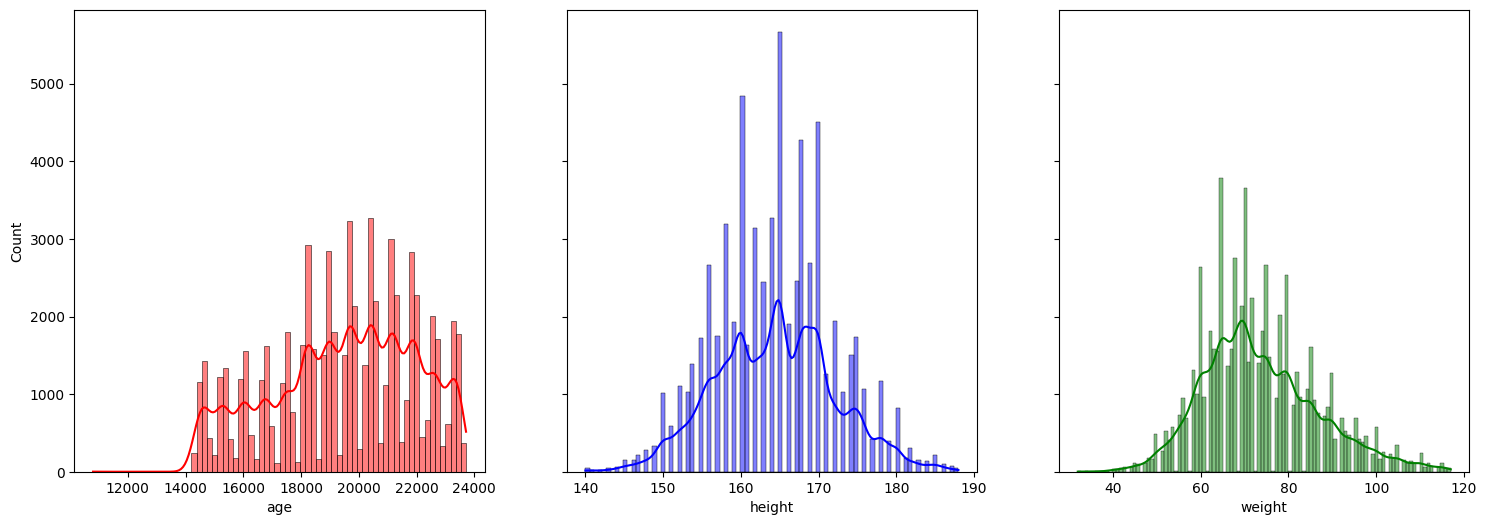

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(df, ax=axes[0], x="age", kde=True, color='r')
sns.histplot(df, ax=axes[1], x="height", kde=True, color='b')
sns.histplot(df, ax=axes[2], x="weight", kde=True, color='g')

<Axes: xlabel='ap_lo', ylabel='Count'>

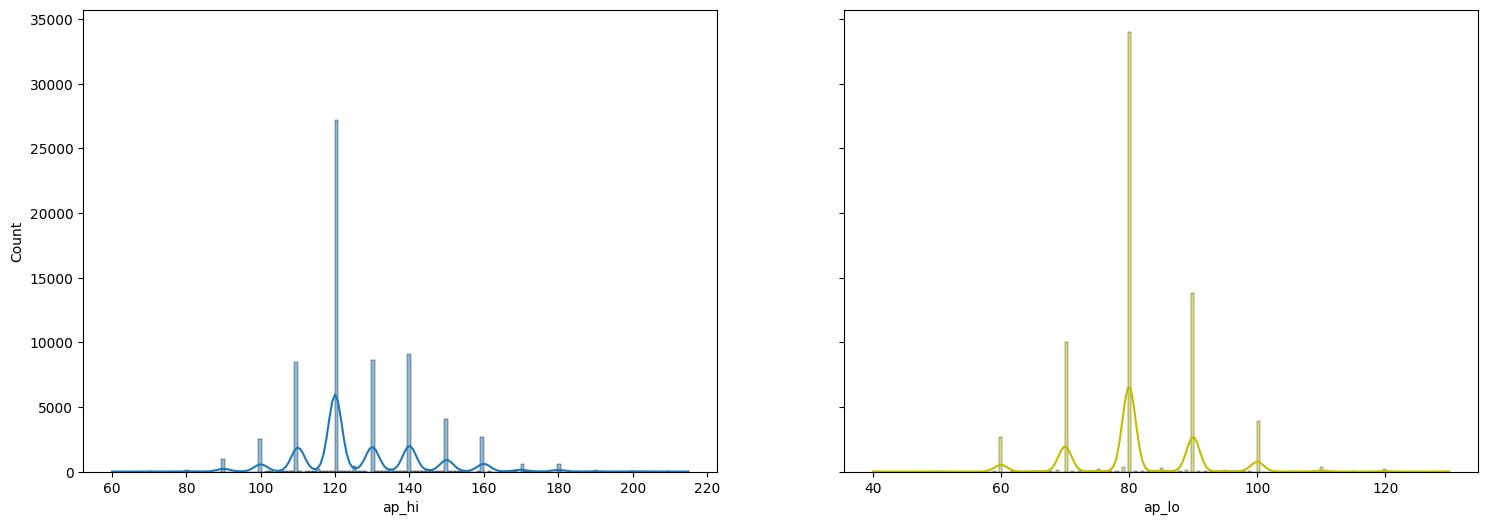

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
sns.histplot(df, ax=axes[0], x="ap_hi", kde=True)
sns.histplot(df, ax=axes[1], x="ap_lo", kde=True, color='y')

In [5]:
df, groups = set_discrete_columns(df, ["age", "ap_hi", "ap_lo"])

# Decyzje projektowe
- Cechy, których histogramy były znacząco różne od wykresu gęstości rozkładu normalnego zostały zdyskretyzowane (age, ap_hi, ap_lo).
- Model sieci bayesa traktuje cechę jako dyskretną jeśli liczba jej unikalnych wartości jest mniejsza od threshholdu (w tym przypadku 10), w przeciwnym przypadku jest traktowana jako ciągła.
- Podczas treningu tworzone są dwa słowniki parametrów: Dla cech dyskretnych categorical_probs przechowuje prawdopodobieństwa dla każdej kombinacji cechy, unikalnej wartości i etykiety; Dla cech ciągłych continous_stats przechowuje wartość oczekiwaną oraz odchylenie standardowe dla każdej kombinacji cechy i etykiety.
# Trening

### Zwykła walidacja

In [6]:
normal_val_params = [(0.1, 0.2), (0.2, 0.2), (0.2, 0.3), (0.3, 0.1), (0.3, 0.2)]
kval_params = [(0.1, 3), (0.1, 5), (0.2, 5), (0.2, 10), (0.3, 3), (0.3, 7)]
results_normal, params_normal, test_data_normal = experiment(df, "cardio", normal_val_params, "normal")
results_kval, params_kval, test_data_kval = experiment(df, "cardio", kval_params, "cross")
df1 = pd.DataFrame(results_normal)
df2 = pd.DataFrame(results_normal)
df1

,Test split,Train split,Val split,Train accuracy,Validation accuracy
0,0.1,0.72,0.18,0.724,0.720
1,0.2,0.64,0.16,0.724,0.721
2,0.2,0.56,0.24,0.723,0.724
3,0.3,0.63,0.07,0.724,0.722
4,0.3,0.56,0.14,0.724,0.720


### Walidacja krzyżowa

In [7]:
df2 = pd.DataFrame(results_kval)
df2

,Test split,Train split,N splits,Train accuracy,Validation accuracy
0,0.1,0.9,3,0.724,0.724
1,0.1,0.9,5,0.724,0.723
2,0.2,0.8,5,0.723,0.723
3,0.2,0.8,10,0.723,0.723
4,0.3,0.7,3,0.723,0.723
5,0.3,0.7,7,0.723,0.724


## Dokładność w zbiorze testowym dla zwykłej walidacji

In [14]:
test_network = NaiveBayesian()
test_network.set_parameters(*params_normal[1])
pred_normal = test_network.predict(test_data_normal[1][0])
test_accuracy_normal = accuracy_score(test_data_normal[1][1], pred_normal)
test_accuracy_normal

0.7258497316636852

## Dokładność w zbiorze testowym dla walidacji krzyżowej

In [10]:
test_network.set_parameters(*params_kval[5])
pred_kval = test_network.predict(test_data_kval[5][0])
test_accuracy_kval = accuracy_score(test_data_kval[5][1], pred_kval)
test_accuracy_kval

0.7248558934605446

# Wnioski
- Dla zadanego zestawu danych naiwny klasyfikator bayesowski osiąga dokładność około 72%.
- W przebiegach z normalną walidacją jej dokładność nieznacznie odbiega od dokładności treningowej.
- We wszystkich przebiegach treningu z walidacją krzyżową dokładność walidacji jest niemal taka sama jak dokładność treningowa oraz dokładność testowa.
- Walidacja krzyżowa ułatwia ocenę oraz wybór odpowiedniego modelu.